# Анализ источников новостей

### Summary meduza

1. Датасет содержит **71 806** текстов из них **1382** дублей. 
2. Нет разделения на рубрики
3. Не пустые столбцы - **date, url, title, text**.
4. В среднем текст содержит **222** слова. 
5. Первая дата публикации - **2014-09-12**, последняя - **2019-08-07**. В среднем в месяц публикуется 1193 статьи

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS 
from pymystem3 import Mystem
from string import punctuation

Загрузим датасет iz. Одновременно сделаем преобразование даты из строки

In [2]:
dateparse = lambda x: pd.datetime.strptime(x, "%Y-%m-%d %H:%M:%S")

In [4]:
data_meduza = pd.read_csv('../../meduza.csv', 
                      escapechar='\\', 
                      parse_dates=['date'],
                      quotechar='\"', 
                      error_bad_lines=False,
                      index_col=False,)

b'Skipping line 47579: expected 17 fields, saw 19\n'


In [5]:
# Проверим преобразование
data_meduza.dtypes

date           datetime64[ns]
url                    object
edition                object
topics                float64
authors               float64
title                  object
text                   object
reposts_fb             object
reposts_vk             object
reposts_ok             object
reposts_twi            object
reposts_lj             object
reposts_tg             object
likes                  object
views                  object
comm_count             object
dtype: object

In [6]:
data_meduza.shape

(71806, 16)

In [7]:
# Так выглядет датасет IZ
data_meduza.head()

,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
0,2019-08-06 14:15:00,https://meduza.io/feature/2019/08/06/matros-ra...,-,NaN,NaN,Матрос разговаривал в казарме по видеосвязи,С марта 2019 года российским военным запрещено...,-,-,-,-,-,-,-,-,-
1,2019-08-06 14:20:00,https://meduza.io/news/2019/08/06/umerla-feshn...,-,NaN,NaN,Умерла фэшн-директор ЦУМа Алла Вербер,"Умерла фэшн-директор московского ЦУМа, вице-пр...",-,-,-,-,-,-,-,-,-
2,2019-08-06 14:10:00,https://meduza.io/feature/2019/08/06/sama-eta-...,-,NaN,NaN,Сама эта мысль казалась дурацкой: роботы-пчелы...,13 августа в издательстве «Эксмо» выходит книг...,-,-,-,-,-,-,-,-,-
3,2019-08-06 14:35:00,https://meduza.io/news/2019/08/06/u-zaderzhann...,-,NaN,NaN,У задержанных на акции за свободные выборы 3 а...,"Некоторые участникиnакции 3 августаn, у которы...",-,-,-,-,-,-,-,-,-
4,2019-08-06 15:00:00,https://meduza.io/feature/2019/08/06/pochemu-v...,-,NaN,NaN,Почему ваш товар плохо продается в интернете?,"Интернет-покупатели становятся все капризнее, ...",-,-,-,-,-,-,-,-,-


In [8]:
#  Проверим повторяющиеся тексты
print('Кол-во одинаковых текстов:',data_meduza.text.duplicated().sum())

data_meduza = data_meduza.drop_duplicates(subset='text')

Кол-во одинаковых текстов: 1382


In [9]:
# Выясним в каким столбцах есть пустые данные
data_meduza.isnull().any()

date           False
url            False
edition        False
topics          True
authors         True
title           True
text            True
reposts_fb     False
reposts_vk     False
reposts_ok     False
reposts_twi    False
reposts_lj     False
reposts_tg     False
likes          False
views          False
comm_count     False
dtype: bool

Как видим, в некоторых столбцах вместо значения Nan используется "-", их преобразованием займемся позже. А пока посмотрим строки, в которых пустые тексты новостей

In [10]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_meduza['text'].isnull().sum())
data_meduza[data_meduza['text'].isnull()]

Кол-во строк с значением NaN в столбце "Text" =  1372


,date,url,edition,topics,authors,title,text,reposts_fb,reposts_vk,reposts_ok,reposts_twi,reposts_lj,reposts_tg,likes,views,comm_count
33,2019-08-06 10:53:00,https://meduza.io/quiz/otlichite-kachestvennyy...,-,NaN,NaN,NaN,NaN,-,-,-,-,-,-,-,-,-


In [11]:
#Удалим эти строки
data_meduza['text'].dropna(inplace=True)

In [12]:
print('Кол-во строк с значением NaN в столбце "Text" = ', data_meduza['text'].isnull().sum())

Кол-во строк с значением NaN в столбце "Text" =  0


Посмотрим сколько элементов Nan в столбце авторов

In [13]:
print('Кол-во строк с значением NaN в столбце "authors" = ', data_meduza['authors'].isnull().sum())
print('Процент статтей без автора: ', np.round(data_meduza['authors'].isnull().sum()/data_meduza.shape[0] *100, 2))

Кол-во строк с значением NaN в столбце "authors" =  70424
Процент статтей без автора:  100.0


Посмотрим, что в столбцах, которые содержат дефис, как обозначение пустых данных

In [14]:
print('edition: ',data_meduza['edition'].unique())
print('reposts_fb: ', data_meduza['reposts_fb'].unique())
print('reposts_vk: ',data_meduza['reposts_vk'].unique())
print('reposts_ok: ',data_meduza['reposts_ok'].unique())
print('reposts_twi: ',data_meduza['reposts_twi'].unique())
print('reposts_lj: ',data_meduza['reposts_lj'].unique())
print('reposts_tg: ',data_meduza['reposts_tg'].unique())
print('likes: ',data_meduza['likes'].unique())
print('views: ',data_meduza['views'].unique())
print('comm_count: ',data_meduza['comm_count'].unique())

edition:  ['-']
reposts_fb:  ['-']
reposts_vk:  ['-']
reposts_ok:  ['-']
reposts_twi:  ['-']
reposts_lj:  ['-']
reposts_tg:  ['-']
likes:  ['-']
views:  ['-']
comm_count:  ['-']


Значений нет, можно удалять

### Рубрики Meduza

In [15]:
# Считаем количество рубрик в данном датасете, а также выведем значения
print('Количество рубрик = ', data_meduza.topics.unique().shape)
data_meduza['topics'].unique()

Количество рубрик =  (1,)


array([nan])

###  Анализ дат

In [16]:
print('Минимальная дата в датасете:', data_meduza.date.min())
print('Максимальная дата в датасете:', data_meduza.date.max())


Минимальная дата в датасете: 2014-09-12 09:04:00
Максимальная дата в датасете: 2019-08-07 05:28:00


In [17]:
data_meduza['month'] = data_meduza.date.apply(lambda x: x.month)
data_meduza['year'] = data_meduza.date.apply(lambda x: x.year)
df = data_meduza.groupby(['year', 'month']).text.nunique().reset_index()
df['month_year'] = df[['month', 'year']].apply(lambda x: '-'.join(['0'+str(x.month) if x.month<10 else str(x.month),
                                                                  str(x.year)]),
                                               axis =1)
df.columns = ['year', 'month', 'nunique_text', 'month_year']
df = df[df.nunique_text>10]
df[['month_year', 'nunique_text']].sort_values('nunique_text', ascending = False).head(10)

,month_year,nunique_text
19,04-2016,1414
18,03-2016,1398
22,07-2016,1392
30,03-2017,1388
23,08-2016,1377
26,11-2016,1370
31,04-2017,1368
15,12-2015,1362
20,05-2016,1350
58,07-2019,1330


In [41]:
df[['month_year', 'nunique_text']].mean()

nunique_text    1193.59322
dtype: float64

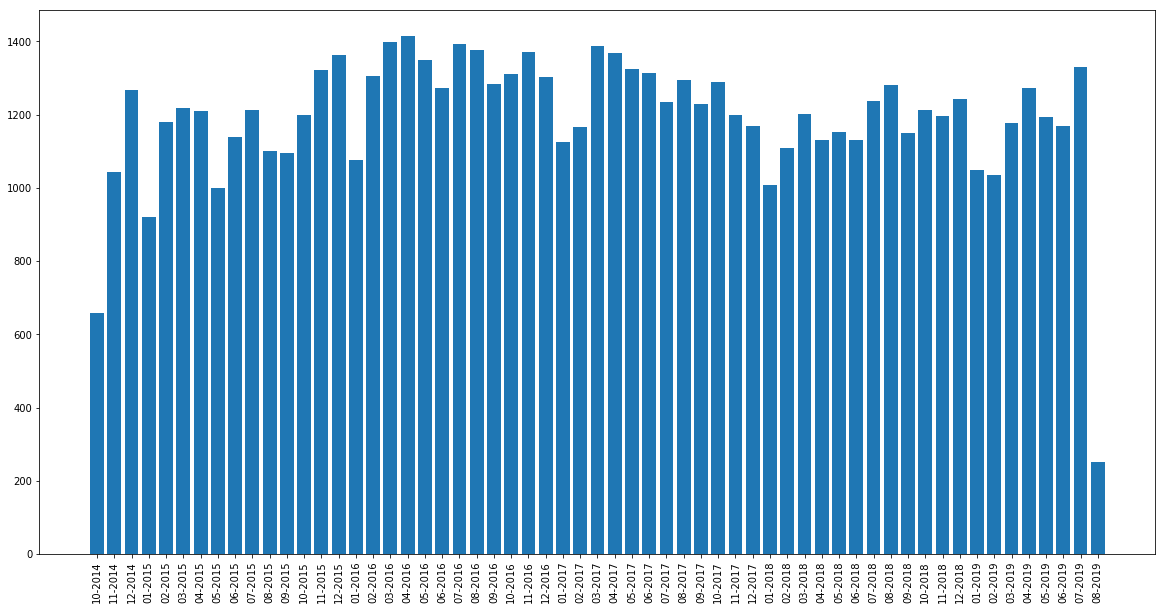

In [18]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.bar(x = df.month_year,
        height = df.nunique_text.values)
plt.xticks(rotation='vertical')
plt.show()

In [37]:
mystem = Mystem() 
stopwords = open('../nlp/preprocessing/stopwords.txt', 'r')
stopwords = stopwords.read().split('\n')
stopwords += ['br', 'также', 'весь', 'это', 'из', 'какой то', 'млн', 'рубль', 
              'именно', 'поэтому', 'либо', 'пока', 'например', 'поскольку','ru', 'n', 'B'
             ]

def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stopwords\
              and token != " " \
              and token.strip() not in punctuation]
    
    text = " ".join(tokens)
    
    return text

In [38]:
data_meduza['preprocessed_text'] = data_meduza.text.apply(lambda x:preprocess_text(x) if pd.isna(x)==False else '')

In [39]:
texts = ' '.join(data_meduza.preprocessed_text.tolist())

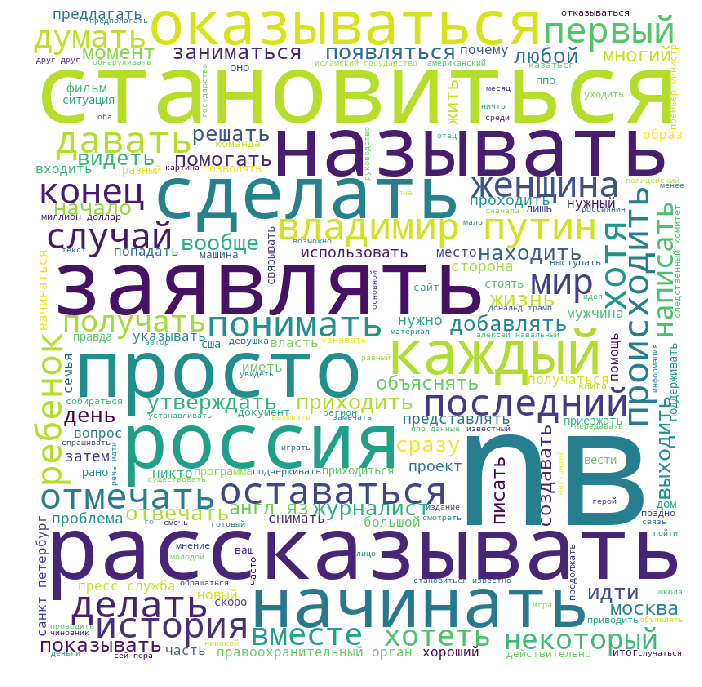

In [40]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(texts) 
fig = plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()